C:\Users\tobia\AppData\Local\Temp\ipykernel_6120\593473946.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_data['parkingTime'] = (site_data['disconnectTime'] - site_data['connectionTime']).dt.total_seconds() / 60
C:\Users\tobia\AppData\Local\Temp\ipykernel_6120\593473946.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_data['connectionHour'] = site_data['connectionTime'].dt.hour + site_data['connectionTime'].dt.minute / 60
C:\Users\tobia\AppData\Local\Temp\ipykernel_6120\593473946.py:38: 

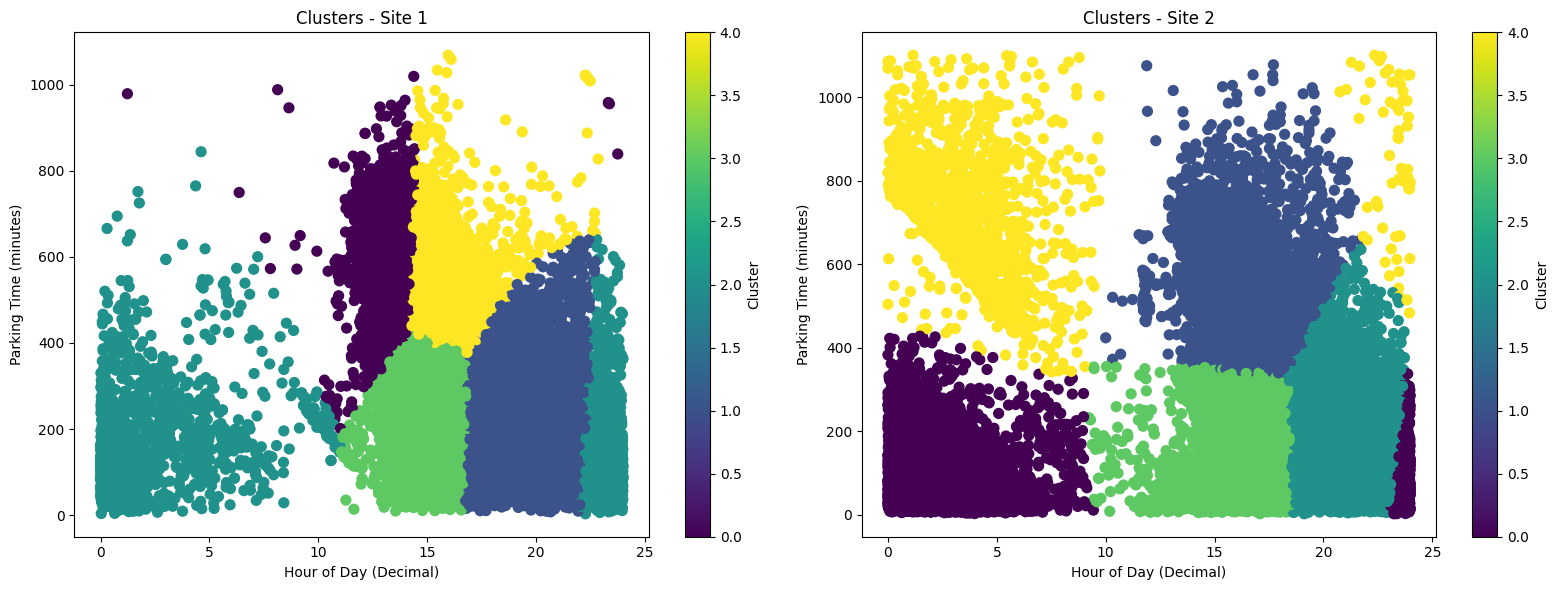

Site 1 - Average Silhouette Coefficient: 0.39
Site 1 - Cluster Statistics:
       Unnamed: 0                        id            connectionTime  \
0               0  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
1               1  5e23b149f9af8b5fe4b973d0 2020-01-02 13:36:50+00:00   
2               2  5e23b149f9af8b5fe4b973d1 2020-01-02 13:56:35+00:00   
3               3  5e23b149f9af8b5fe4b973d2 2020-01-02 13:59:58+00:00   
4               4  5e23b149f9af8b5fe4b973d3 2020-01-02 14:00:01+00:00   
...           ...                       ...                       ...   
66443       10083  5d574ad2f9af8b4c10c03652 2019-07-31 18:08:04+00:00   
66444       10084  5d574ad2f9af8b4c10c03653 2019-07-31 18:40:41+00:00   
66445       10085  5d574ad2f9af8b4c10c03654 2019-07-31 19:04:40+00:00   
66446       10086  5d574ad2f9af8b4c10c03655 2019-07-31 19:19:47+00:00   
66447       10087  5d574ad2f9af8b4c10c03656 2019-07-31 19:21:47+00:00   

                 disconnectTime           doneCh

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

# CSV-Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

def cluster_minute_parkingtime(data, site_id, ncluster):
    # CSV-Daten laden
    file_path = "../data/processed/charging_sessions_cleaned.csv"
    site_data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

    # Filter data for the specific site ID
    site_data = data[data['siteID'] == site_id]

    # Calculate parkingTime
    site_data['parkingTime'] = (site_data['disconnectTime'] - site_data['connectionTime']).dt.total_seconds() / 60

    # Convert 'hour' to decimal format
    site_data['connectionHour'] = site_data['connectionTime'].dt.hour + site_data['connectionTime'].dt.minute / 60


    # Do not remove outliers for 'hour_decimal'; only remove outliers for 'parkingTime'
    Q1_parking = site_data['parkingTime'].quantile(0.25)
    Q3_parking = site_data['parkingTime'].quantile(0.75)
    IQR_parking = Q3_parking - Q1_parking
    lower_bound_parking = Q1_parking - 1.5 * IQR_parking
    upper_bound_parking = Q3_parking + 1.5 * IQR_parking

    site_data_filtered = site_data[(site_data['parkingTime'] >= lower_bound_parking) &
                                   (site_data['parkingTime'] <= upper_bound_parking)]


    site_data_filtered['hour_sin'] = np.sin(2 * np.pi * site_data_filtered['connectionHour'] / 24)
    site_data_filtered['hour_cos'] = np.cos(2 * np.pi * site_data_filtered['connectionHour'] / 24)

    # Select and scale features
    features = site_data_filtered[['hour_sin', 'hour_cos', 'parkingTime']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Determine optimal number of clusters using the Elbow method
    inertia = []
    range_n_clusters = range(1, 10)
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    # Perform clustering with the chosen number of clusters
    optimal_clusters = ncluster
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    site_data_filtered['Cluster'] = clusters

    # Evaluate silhouette score
    silhouette_avg = silhouette_score(features_scaled, clusters)

    # Function to calculate circular mean for 'hour_decimal'
    def calculate_circular_mean(hour_series):
        hour_sin = np.sin(2 * np.pi * hour_series / 24)
        hour_cos = np.cos(2 * np.pi * hour_series / 24)
        mean_sin = np.mean(hour_sin)
        mean_cos = np.mean(hour_cos)
        mean_angle = np.arctan2(mean_sin, mean_cos)
        mean_hour = (mean_angle * 24 / (2 * np.pi)) % 24
        return mean_hour

    # Aggregate cluster statistics
    cluster_stats = site_data_filtered.groupby('Cluster').agg({
        'connectionHour': ['count', calculate_circular_mean],
        'parkingTime': ['mean', 'median']
    }).sort_index().round(2)

    # Rename columns for clarity
    cluster_stats.columns = ['count', 'circular_mean_hour_decimal', 'mean_parkingTime', 'median_parkingTime']

    return inertia, clusters, features, site_data_filtered, silhouette_avg, cluster_stats

# Perform clustering for siteID 1 and siteID 2
inertia_1, clusters_1, features_1, filtered_data_1, silhouette_1, stats_1 = cluster_minute_parkingtime( df,site_id=1, ncluster=5)
inertia_2, clusters_2, features_2, filtered_data_2, silhouette_2, stats_2 = cluster_minute_parkingtime( df,site_id=2, ncluster=5)


# Plot Clustering Results for both sites
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter1 = axes[0].scatter(filtered_data_1['connectionHour'], filtered_data_1['parkingTime'], c=clusters_1, cmap='viridis', s=50)
axes[0].set_title('Clusters - Site 1')
axes[0].set_xlabel('Hour of Day (Decimal)')
axes[0].set_ylabel('Parking Time (minutes)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(filtered_data_2['connectionHour'], filtered_data_2['parkingTime'], c=clusters_2, cmap='viridis', s=50)
axes[1].set_title('Clusters - Site 2')
axes[1].set_xlabel('Hour of Day (Decimal)')
axes[1].set_ylabel('Parking Time (minutes)')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# Display Silhouette Scores and Cluster Statistics
print(f"Site 1 - Average Silhouette Coefficient: {silhouette_1:.2f}")
print("Site 1 - Cluster Statistics:")
print(stats_1)

print("\n" + "="*50 + "\n")

print(f"Site 2 - Average Silhouette Coefficient: {silhouette_2:.2f}")
print("Site 2 - Cluster Statistics:")
print(stats_2)
